In [2]:
# %% import libraries
import os
import glob
import numpy as np
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16, 3.5)
plt.rcParams['figure.dpi'] = 150

import warnings

warnings.filterwarnings('ignore')

In [3]:
def read_program(data_folder, validate_folders, program_no, drop_cols):
    program = os.listdir(os.path.join(data_folder, validate_folders[program_no], 'One_Die'))
    program = [csv_file for csv_file in program if csv_file.endswith('.csv')]

    df = []
    for csv_file in program:
        csv_path = os.path.join(data_folder, validate_folders[program_no], 'One_Die', csv_file)
        df.append(pd.read_csv(csv_path, header=0).reset_index(drop=True).drop(drop_cols, axis=1))
    
    df = pd.concat(df, ignore_index=True)
    return df

def get_label(validate_file, program_no):
    validate_program = validate_file.get_group(program_no)['rawdata']
    return validate_program

In [33]:
from scipy import signal
from peakdetect import peakdetect
from scipy.signal import savgol_filter
import ruptures as rpt

def peak_detection(array, look_ahead=500, diff_threshold=0.01):
    # lookahead is the distance to look ahead from a peak to determine if it is the actual peak.
    peaks = peakdetect(array, lookahead=look_ahead, delta=diff_threshold)
    higherPeaks = np.array([ii[0] for ii in peaks[0]], dtype=int)
    lowerPeaks = np.array([ii[0] for ii in peaks[1]], dtype=int)
    print(higherPeaks)
    
    # modified for the case piezo drop not so significantly
    for ii, high_peak in enumerate(higherPeaks):
        current_look_ahead = array[high_peak: high_peak + look_ahead]
        look_ahead_dif = np.absolute(current_look_ahead - array[high_peak])
        no_significant_index = look_ahead_dif[look_ahead_dif < diff_threshold].shape[0]
        higherPeaks = np.append(higherPeaks, no_significant_index)

    peak_lists_ = np.concatenate([higherPeaks, lowerPeaks])

    return np.sort(peak_lists_)

def change_slope_detection(array, window=500, poly=3, deriv=3):
    der2 = savgol_filter(array, window_length=window, polyorder=poly, deriv=deriv)
    max_der2 = np.max(np.abs(der2))
    large = np.where(np.abs(der2) > max_der2 / 2)[0]
    gaps = np.diff(large) > window
    begins = np.insert(large[1:][gaps], 0, large[0])
    ends = np.append(large[:-1][gaps], large[-1])
    changes = ((begins + ends) / 2).astype(np.int32)

    return changes

def butter_highpass(cut=0.5, order=5):
    b, a = signal.butter(order, cut, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cut, order=5):
    b, a = butter_highpass(cut, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [5]:
label_df = pd.read_excel('點位定義.xlsm', sheet_name='原始資料vs平滑資料')
label_df = label_df[label_df['rawdata'].isna() == False]
label_df_group = label_df.groupby('program')  
validate_programs = [program for program, group in label_df_group]

In [6]:
data_folder = \
        '/Users/hlinh96it/Library/CloudStorage/OneDrive-NTHU/ASE_PHM_WireBonding/dataset/10_DAQ_20221227'
validate_folders = os.listdir(data_folder)
validate_folders = [folder for folder in validate_folders if folder[2:] in validate_programs]

In [7]:
drop_cols = ['Date_Time', 'X', 'Y', 'id']
program_1 = read_program(data_folder, validate_folders, program_no=0, drop_cols=drop_cols)
label_program_1 = label_df_group

### Data visualization

In [14]:
program_1 = program_1[968000: 1300000].copy()

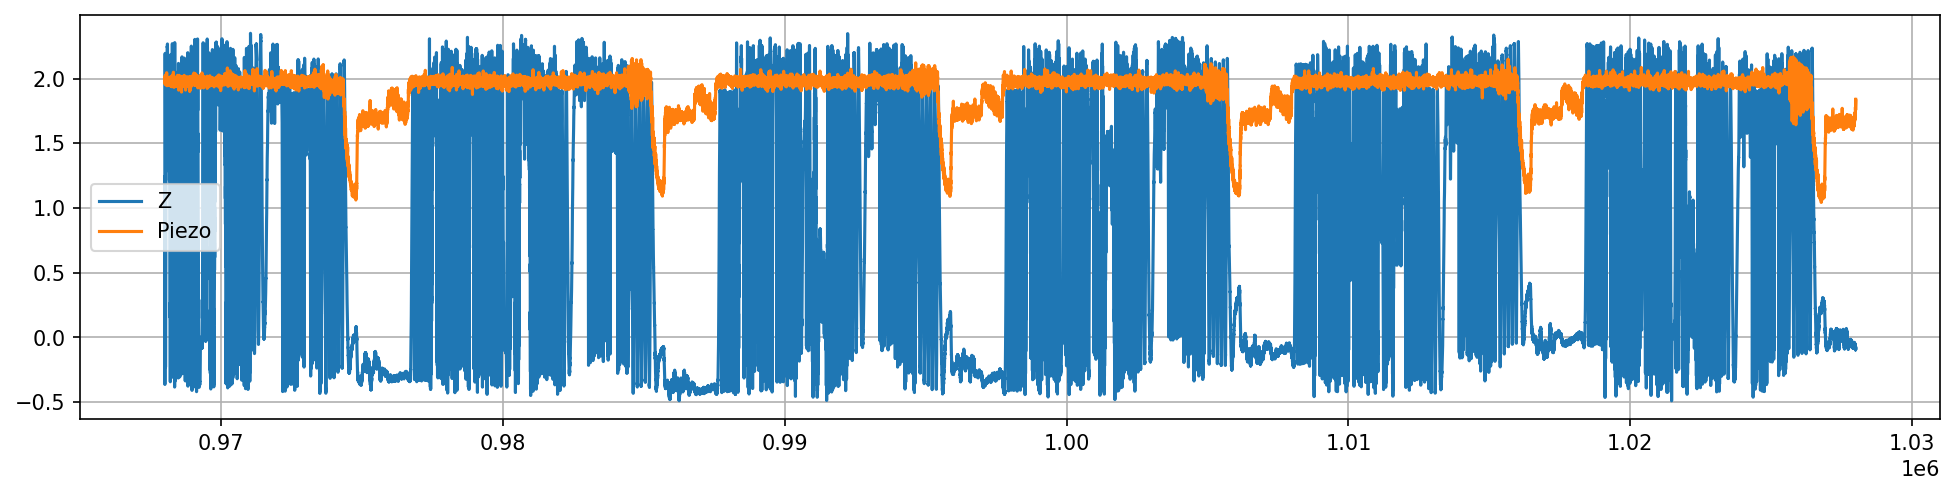

In [15]:
start, end = 0, 60000
program_1[start: end].plot()
plt.show()

In [16]:
crop_label = get_label(label_df_group, program_no=validate_programs[0])
crop_label = crop_label[(crop_label >= start) & (crop_label <= end)]

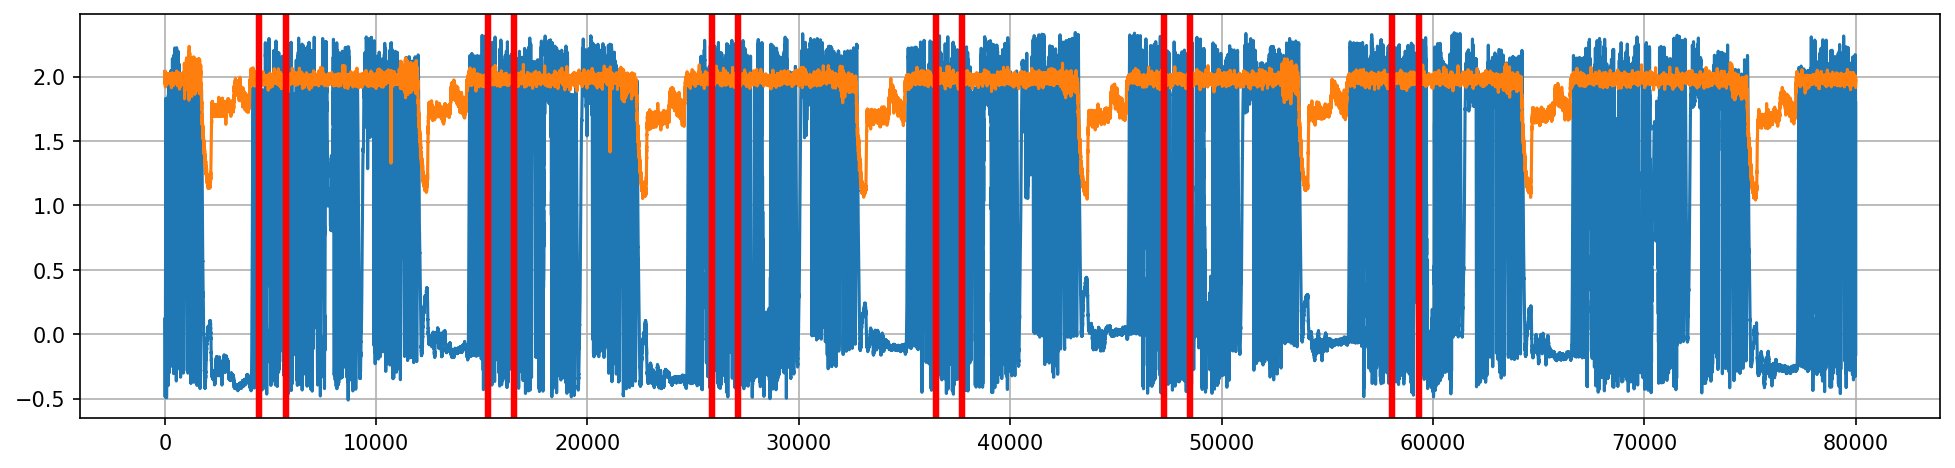

In [37]:
plt.plot(program_1[start: end].values)
for idx in crop_label:
    plt.axvline(idx, c='r', linewidth=3.0)
plt.show()

### Validate method for labeled data

In [28]:
start, end = 120000, 200000

In [34]:
piezo = program_1[start: end]['Piezo'].copy()

dary = piezo.rolling(window=200, min_periods=1).mean().values
dary -= np.average(dary)

# %% using cumulative sum method
dary_step = np.cumsum(dary)
dary_step = (dary_step - dary_step.min()) / (dary_step.max() - dary_step.min())
crop_idx = peak_detection(dary_step, look_ahead=100, diff_threshold=0.0001)
# crop_idx = change_slope_detection(dary_step, 500, 2, 2)

# insert 0 and end points
crop_idx = np.insert(crop_idx, [0, crop_idx.shape[0]], [0, crop_idx.shape[0]])

# %% create crop pair instead of just cutting indices
crop_idx_pair = []
for idx, val in enumerate(crop_idx):
    try:
        crop_idx_pair.append([val, crop_idx[idx + 1]])
    except IndexError:
        pass

crop_idx_pair = np.array(crop_idx_pair, dtype=int)
crop_idx_pair = crop_idx_pair.flatten()

[ 1795  3563 12035 22347 32753 43236 53684 64235 74885]


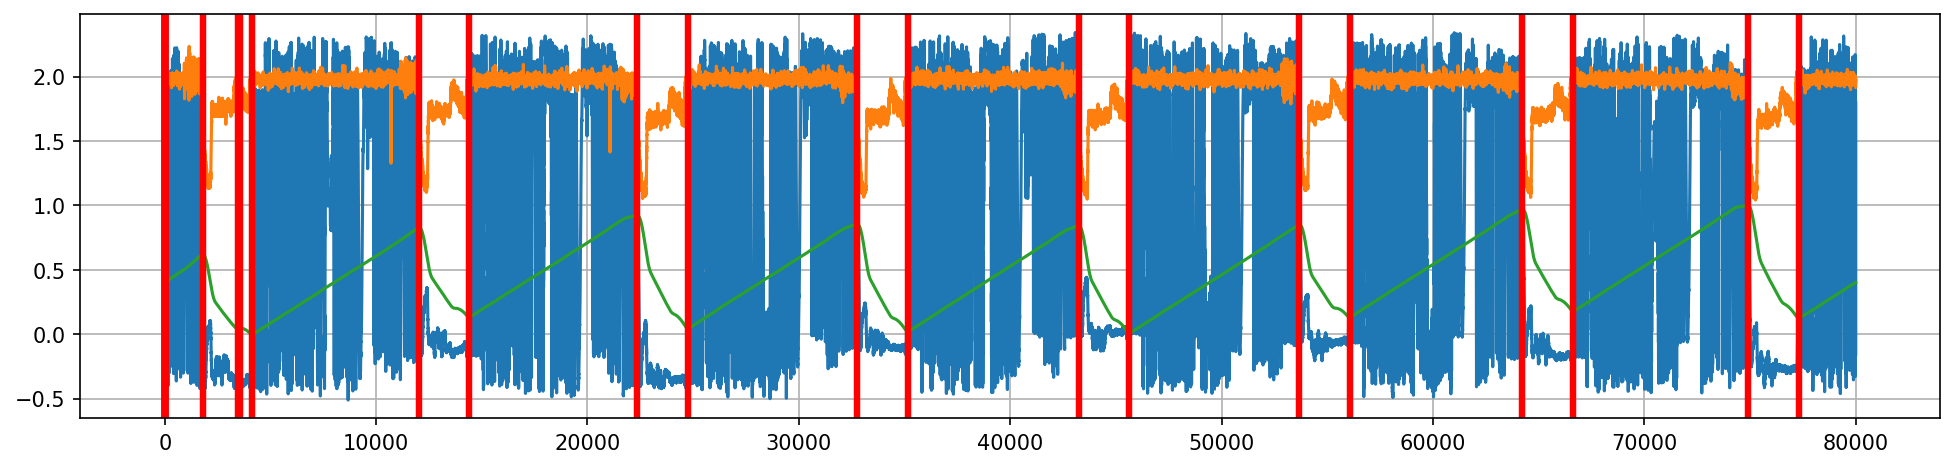

In [36]:
plt.plot(program_1[start: end].values)
plt.plot(dary_step)
for idx in crop_idx_pair:
    plt.axvline(idx, c='r', linewidth=3.0)
plt.show()